In [ ]:
# Nate Brunacini, nbrunaci@u.rochester.edu
# Supervisor: Kelly A. Douglass
# This file includes methods used to calculate the metallicity value at each spaxel in a MaNGA galaxy using the "3D" 
# method (referred to in code as "R") described in the 2016 paper by Pilyugin and Grebel.

In [1]:
# Import packages

import marvin
from marvin.tools.maps import Maps
from marvin.tools import Image

import numpy as np
import numpy.ma as ma
from numpy import log10, pi

import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.constants as const

import math

/home/nbrunaci/.local/lib/python3.9/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR15
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


In [51]:
# Takes in plate and IFU numbers of a galaxy, returns nested dictionary of each relevent emission line's flux and inverse variance in masked arrays
# Called by addDiagnostics_Pilyugin function
# Could probably by merged with the addDiagnostics function
def getDataMaps_Pilyugin(plateifu):
    maps = Maps(plateifu)
    
    # Obtaining redshift data from drpall fits file
    with fits.open('drpall-v2_4_3.fits', memmap=True) as drpall:
        tbdata = drpall[1].data
        ind = np.where(tbdata['plateifu'] == plateifu)
        redshift = tbdata['nsa_z'][ind][0]# This [0] is here because each z value seems to be in its own array for some reason
    
    # Observed emission lines
    HbF_map = maps["emline_gflux_hb_4862"]
    OII_map = maps["emline_gflux_oii_3727"]
    OIII_map = maps["emline_gflux_oiii_5008"]
    OIII2_map = maps["emline_gflux_oiii_4960"]
    NII_map = maps["emline_gflux_nii_6585"]
    NII2_map = maps["emline_gflux_nii_6549"]
    HaF_map = maps["emline_gflux_ha_6564"]
    observed = [HbF_map,OII_map,OIII_map,OIII2_map,NII_map,NII2_map,HaF_map]# Array of observed emission lines
    names = ['HbF','OII','OIII','OIII2','NII','NII2','HaF']# Array of names of observed emission lines
    
    # Array of masked flux arrays for observed emission lines
    observed_m = []
    for line in observed:
        observed_m.append(line.masked)
    
    # Array of masked inverse variance arrays for observed emission lines
    observed_ivar_m = []
    for line in observed:
        observed_ivar_m.append(ma.array(line.ivar,mask=line.mask))
    
    return{
        'z': redshift,
        names[0]: {'flux': observed_m[0], 'ivar': observed_ivar_m[0]},
        names[1]: {'flux': observed_m[1], 'ivar': observed_ivar_m[1]},
        names[2]: {'flux': observed_m[2], 'ivar': observed_ivar_m[2]},
        names[3]: {'flux': observed_m[3], 'ivar':observed_ivar_m[3]},
        names[4]: {'flux': observed_m[4], 'ivar': observed_ivar_m[4]},
        names[5]: {'flux': observed_m[5], 'ivar': observed_ivar_m[5]},
        names[6]: {'flux': observed_m[6], 'ivar': observed_ivar_m[6]}
    }

In [52]:
# Takes in output from getDataMaps_Pilyugin function, returns dictionary of inverse variance arrays for calculated abundance diagnostics
# Called by addDiagnostics_Pilyugin function
def getDiagnosticIvars_Pilyugin(observed):
    
    # Fluxes
    b = observed['HbF']['flux']
    oii = observed['OII']['flux']
    oiii = observed['OIII']['flux']
    oiii2 = observed['OIII2']['flux']
    nii = observed['NII']['flux']
    nii2 = observed['NII2']['flux']
    
    # Inverse variances
    ib = observed['HbF']['ivar']
    ioii = observed['OII']['ivar']
    ioiii = observed['OIII']['ivar']
    ioiii2 = observed['OIII2']['ivar']
    inii = observed['NII']['ivar']
    inii2 = observed['NII2']['ivar']
    
    # R2 ivar calculations:
    # R2 = f(o,b) where o=OII, b=HbF
    # f = o/b
    # ivar_f = 1.0 / ( (df/do)**2/ivar_o + (df/db)**2/ivar_b ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( 1.0/(b**2*ivar_o) + o**2/(b**4*ivar_b) )
    R2_ivar_m = 1.0 / (1.0/(b**2*ioii) + oii**2/(b**4*ib))
    
    # N2 ivar calculations:
    # N2 = f(n,n2,b) where n=NII, n2=NII2, b=HbF
    # f = (n+n2)/b
    # ivar_f = 1.0 / ( (df/dn)**2/ivar_n + (df/dn2)**2/ivar_n2 + (df/db)**2/ivar_b ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( 1.0/(b**2*ivar_n) + 1.0/(b**2*ivar_n2) + (-(n+n2)/b**2)**2/ivar_b )
    N2_ivar_m = 1.0 / (1.0/(b**2*inii) + 1.0/(b**2*inii2) + (-(nii+nii2)/b**2)**2/ib)
    
    # R3 ivar calculations:
    # R3 = f(o,o2,b) where o=OIII, o2=OIII2, b=HbF
    # f = (o+o2)/b
    # ivar_f = 1.0 / ( (df/do)**2/ivar_o + (df/do2)**2/ivar_o2 + (df/db)**2/ivar_b ) where d means partial derivative
    # Evaluated: ivar_f = 1.0 / ( 1.0/(b**2*ivar_o) + 1.0/(b**2*ivar_o2) + (-(o+o2)/b**2)**2/ivar_b )
    R3_ivar_m = 1.0 / (1.0/(b**2*ioiii) + 1.0/(b**2*ioiii2) + (-(oiii+oiii2)/b**2)**2/ib)
    
    return {
        'R2':R2_ivar_m,
        'N2':N2_ivar_m,
        'R3':R3_ivar_m
    }

In [53]:
# Takes in plate and IFU numbers of a galaxy, returns dictionary of observed lines from getDataMaps_Pilyugin function plus calculated abundance diagnostics
# NOTE: This function cannot be merged with addDiagnostics because the two have different N2 ratios
def addDiagnostics_Pilyugin(plateifu):
    observed = getDataMaps_Pilyugin(plateifu)
    
#     fluxes = [flux for flux in observed.items()]# Creates array of the same maps as accessed below but lacks names
    HbF_flux_m = observed['HbF']['flux']
    OII_flux_m = observed['OII']['flux']
    OIII_flux_m = observed['OIII']['flux']
    OIII2_flux_m = observed['OIII2']['flux']
    NII_flux_m = observed['NII']['flux']
    NII2_flux_m = observed['NII2']['flux']
    
    # Flux for calculated abundance diagnostics (masked)
    R2_flux_m = OII_flux_m / HbF_flux_m
    N2_flux_m = (NII_flux_m + NII2_flux_m) / HbF_flux_m
    R3_flux_m = (OIII_flux_m + OIII2_flux_m) / HbF_flux_m
    
    # Inverse variance for calculated abuance diagnostics (masked)
    dIvars = getDiagnosticIvars_Pilyugin(observed)
    
    diagnostics = {
        'R2': {'flux': R2_flux_m, 'ivar': dIvars['R2']},
        'N2': {'flux': N2_flux_m, 'ivar': dIvars['N2']},
        'R3': {'flux': R3_flux_m, 'ivar': dIvars['R3']}
    }
    return observed | diagnostics

In [54]:
# Takes in output from addDiagnostics function, returns dictionary of inverse variance arrays for each metallicity method
# Called by findMetallicities function
def getMetallicityIvars_Pilyugin(eqtype,r3,r2,n2,ir3,ir2,in2):
    
    #NOTE: ma.log in natural log (ln)
    
    # Constants
    if eqtype == 'lower':
        A = 7.932
        B = 0.944
        C = 0.695
        D = 0.970
        E = -0.291
        F = -0.019
    else:
        A = 8.589
        B = 0.022
        C = 0.399
        D = -0.137
        E = 0.164
        F = 0.589
    ln10 = ma.log(10)
    
    # R metallicity ivar calculations:
    # R_metallicity = f(r3,r2,n2)
    # f = A + B * ma.log10(r3/r2) + C * ma.log10(n2) + (D + E * ma.log10(r3/r2) + F * ma.log10(n2)) * ma.log10(r2)
    dfdr3 = (E*ma.log(r2)+B*ln10)/(r3*ln10**2)
    dfdr2 = -(E*ma.log(r2)-E*ma.log(r3/r2)-F*ma.log(n2)-D*ln10+B*ln10)/(r2*ln10**2)
    dfdn2 = (F*ma.log(r2)+C*ln10)/(n2*ln10**2)
    R_metallicity_ivar = 1.0 / ( (dfdr3)**2/ir3 + (dfdr2)**2/ir2 + (dfdn2)**2/in2 )
    
    return R_metallicity_ivar

In [81]:
# Takes in output from addDiagnostics_Pilyugin function, calculates and returns metallicities calculated using equations from Pilyugin and Grebel 2016 and their inverse variances
# dataMaps must be a dictionary of the masked flux and ivar of each emission line, as is output by addDiagnostics_Pilyugin
def findMetallicities_Pilyugin(dataMaps):
    
    R3 = dataMaps['R3']['flux']
    R2 = dataMaps['R2']['flux']
    N2 = dataMaps['N2']['flux']
    ratio = R3/R2
    R3_ivar = dataMaps['R3']['ivar']
    R2_ivar = dataMaps['R2']['ivar']
    N2_ivar = dataMaps['N2']['ivar']
    
    R_metallicity = np.empty_like(N2)
    R_ivar = np.empty_like(N2)
    for i in range(0,len(R_metallicity)):
        for j in range(0,len(R_metallicity[i])):
            
            R3val = R3[i][j]
            R2val = R2[i][j]
            N2val = N2[i][j]
            logratio = ma.log10(ratio[i][j])
            
            if ma.log10(N2[i][j]) < -0.6:
                # RL metallicity equation (Pilyugin et al. Eq. 5)
                R_metallicity[i][j] = 7.932 + 0.944 * logratio + 0.695 * ma.log10(N2val) + (0.970 - 0.291 * logratio - 0.019 * ma.log10(N2val)) * ma.log10(R2val)
                R_ivar[i][j] = getMetallicityIvars_Pilyugin('lower',R3val,R2val,N2val,R3_ivar[i][j],R2_ivar[i][j],N2_ivar[i][j])
            else:
                # RU metallicity equation (Pilyugin et al. Eq. 4)
                R_metallicity[i][j] = 8.589 + 0.022 * logratio + 0.399 * ma.log10(N2val) + (-0.137 + 0.164 * logratio + 0.589 * ma.log10(N2val)) * ma.log10(R2val)
                R_ivar[i][j] = getMetallicityIvars_Pilyugin('upper',R3val,R2val,N2val,R3_ivar[i][j],R2_ivar[i][j],N2_ivar[i][j])
            
            # Mask any spaxels with a HaF signal-to-noise ratio of less than 5
            if dataMaps['HaF']['flux'][i][j] * math.sqrt(dataMaps['HaF']['ivar'][i][j]) < 5:
                R_metallicity.mask[i][j] = True
                R_ivar.mask[i][j] = True
    
    return{
        'R':{'metallicity': R_metallicity, 'ivar': R_ivar}
    }

In [82]:
# # Pilyugin method
# plateifu_R = '9487-12701'
# objmaps_R = addDiagnostics_Pilyugin(plateifu_R)
# results_R = findMetallicities_Pilyugin(objmaps_R)

[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in double_scalars (RuntimeWarning)


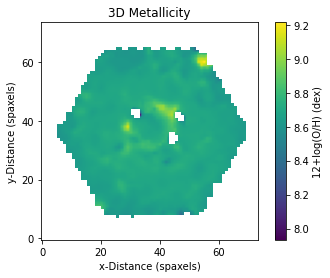

In [83]:
# plt.imshow(results_R['R']['metallicity'])#,vmin=8.5,vmax=9.5)
# plt.gca().invert_yaxis()
# plt.locator_params(axis='y', nbins=5)
# plt.title('3D Metallicity')
# plt.xlabel('x-Distance (spaxels)')
# plt.ylabel('y-Distance (spaxels)')
# plt.colorbar(label='12+log(O/H) (dex)')
# # plt.savefig('PosterMaps/N2metallicity_9487-12701')

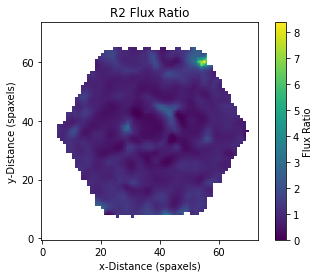

In [27]:
# plt.imshow(objmaps_R['R2']['flux'])#,vmin=8.5,vmax=9.5)
# plt.gca().invert_yaxis()
# plt.locator_params(axis='y', nbins=5)
# plt.title('R2 Flux Ratio')
# plt.xlabel('x-Distance (spaxels)')
# plt.ylabel('y-Distance (spaxels)')
# plt.colorbar(label='Flux Ratio')
# plt.savefig('PosterMaps_Updated/R2Flux_9487-12701')

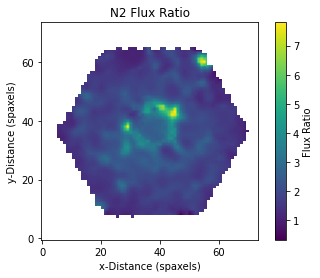

In [28]:
# plt.imshow(objmaps_R['N2']['flux'])#,vmin=8.5,vmax=9.5)
# plt.gca().invert_yaxis()
# plt.locator_params(axis='y', nbins=5)
# plt.title('N2 Flux Ratio')
# plt.xlabel('x-Distance (spaxels)')
# plt.ylabel('y-Distance (spaxels)')
# plt.colorbar(label='Flux Ratio')
# plt.savefig('PosterMaps_Updated/N2Flux_9487-12701')

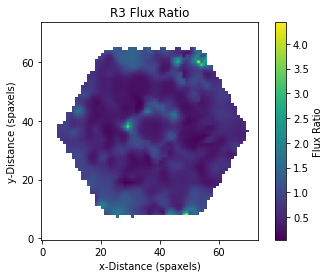

In [29]:
# plt.imshow(objmaps_R['R3']['flux'])#,vmin=8.5,vmax=9.5)
# plt.gca().invert_yaxis()
# plt.locator_params(axis='y', nbins=5)
# plt.title('R3 Flux Ratio')
# plt.xlabel('x-Distance (spaxels)')
# plt.ylabel('y-Distance (spaxels)')
# plt.colorbar(label='Flux Ratio')
# plt.savefig('PosterMaps_Updated/R3Flux_9487-12701')